In [5]:
import json 
import numpy as np 
import networkx as nx

import matplotlib.pyplot as plt

In [6]:
with open("dataset/mutag.json", 'r') as f:
    draw_data = json.load(f)


draw_features = draw_data["node_feat"]
draw_edge_index = draw_data["edge_index"]
draw_y = draw_data["y"]
draw_num_nodes = draw_data["num_nodes"]

In [7]:
def create_graph(ind):
    G = nx.Graph()
    # Add nodes
    for node in range(draw_num_nodes[ind]):
        G.add_node(node)

    # Add edges
    edges = np.array(draw_edge_index[ind]).T
    for source, target in edges:
        G.add_edge(source, target)
    
    return G

In [8]:
def plot(ind):
    G = create_graph(ind)

    node_colors = [sum(i*f for i, f in enumerate(feature)) for feature in draw_features[ind]]

    # Drawing the graph
    plt.figure()
    nx.draw(G, with_labels=True, node_color=node_colors, node_size=700, edge_color='k')
    plt.show()

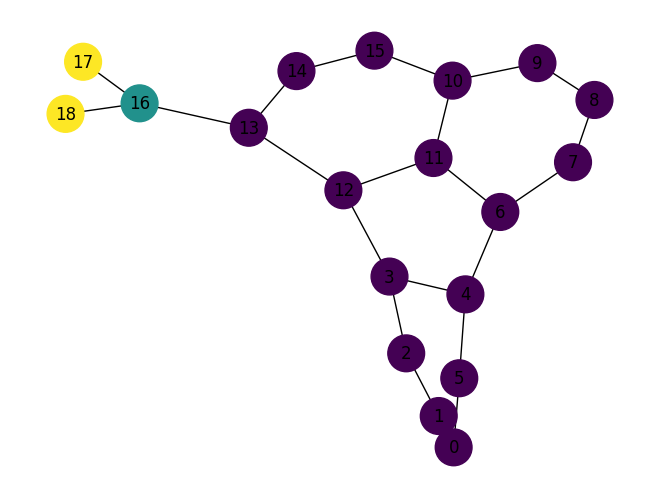

In [9]:
plot(3)

### Visualize P 

In [10]:
import json 
import numpy as np 
import torch
from tqdm import tqdm 
import networkx as nx
import pandas as pd 

from fugw_solver.solver import solver
import ot

from collections import defaultdict

import multiprocessing

def adjacency_to_distance_matrix(adj):
    G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
    length = dict(nx.all_pairs_shortest_path_length(G))
    num_nodes = adj.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            try:
                distance_matrix[i, j] = length[i][j]
            except KeyError:  # no path between i and j
                distance_matrix[i, j] = np.inf  # or some large number to denote no path
    return distance_matrix

def distances(i, rho, alpha, features, distance_matrices, y, pot):
    source_features = torch.tensor(features[i]).T.float()
    source_geometry = torch.tensor(distance_matrices[i]).float()
    distances = []

    for j, (target_features, target_geometry, classif) in enumerate(zip(features, distance_matrices, y)):
        if j == i:
            continue
        target_features = torch.tensor(target_features).T.float()
        target_geometry = torch.tensor(target_geometry).float()
    
        if pot:
            C1 = ot.dist(source_geometry)
            C2 = ot.dist(target_geometry)
            M = ot.dist(source_features.T, target_features.T)
            Gwg, logw = ot.fused_gromov_wasserstein(M, C1, C2, log=True, alpha=alpha)
            loss = logw["fgw_dist"]
        else:
            P, loss_ls = solver(source_features, target_features, source_geometry, target_geometry, rho=rho, alpha=alpha, nits_bcd=10, nits_uot=100)
            loss = loss_ls[-1]["total"]
        distances.append((loss, P, i, j))


    distances.sort(key=lambda x: x[0])
    return distances

In [11]:
with open("dataset/mutag.json", 'r') as f:
    data = json.load(f)


features = data["node_feat"]
y = data["y"]
y = list(map(lambda x: x[0], y))
distance_matrices = []
for (sources, targets), num_nodes in zip(data["edge_index"], data["num_nodes"]):
    adj = np.zeros((num_nodes, num_nodes))
    adj[sources, targets] = 1
    distance_matrix = adjacency_to_distance_matrix(adj)
    distance_matrices.append(distance_matrix)

In [12]:
ind = 3
distances = distances(i=ind, rho=0.5, alpha=0.5, features=features, distance_matrices=distance_matrices, y=y, pot=False)
distances

[(0.05460750311613083,
  tensor([[5.0434e-02, 3.6887e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7382e-24,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6798e-19, 5.0434e-02, 9.7391e-24, 0.0000e+00, 0.0000e+00, 6.0713e-39,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 9.7156e-24, 5.0434e-02, 9.7379e-24, 6.0707e-39, 1.1118e-37,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 9.7153e-24, 5.0434e-02, 3.6802e-19, 0.0000e+00,
           4.7494e-41, 0.0000e+00, 0.00

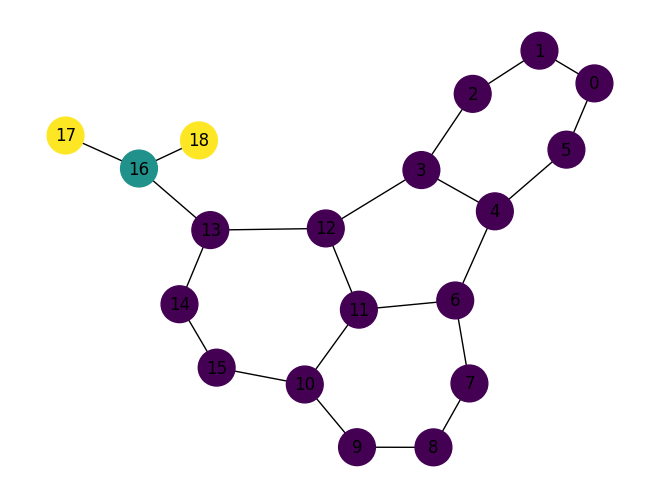

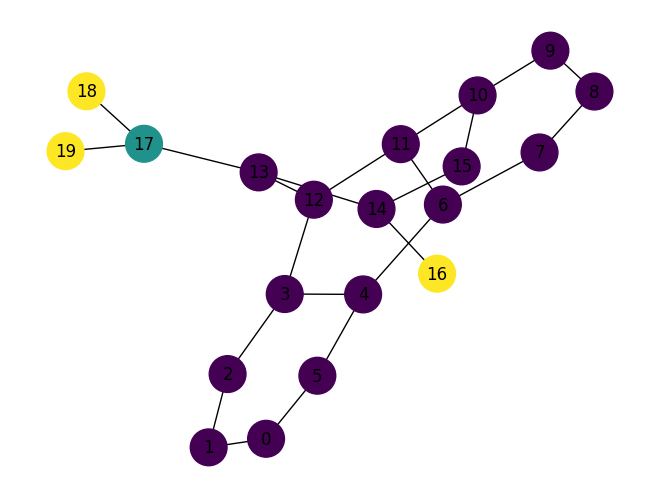

In [13]:
P, source, target = distances[0][1:]
plot(source)
plot(target)

In [30]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color='blue', s=200, label='Source Nodes', depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color='orange', s=200, label='Target Nodes', depthshade=False)

    transport_matrix = P / P.sum(dim=1).reshape(-1, 1)

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            if i in [16,17,18] and j in [16,17,18,19]:
                x1, y1, z1 = pos_source[i]
                x2, y2, z2 = pos_target[j]
                ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

In [21]:
P.sum()

tensor(0.9461)

In [ ]:
source_graph = create_graph(source)
target_graph = create_graph(target)

source_locations = nx.spring_layout(source_graph)
target_locations = nx.spring_layout(target_graph)

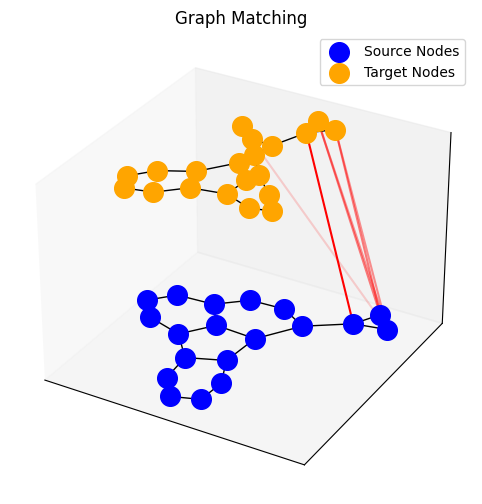

In [31]:
%matplotlib inline
plot_graph_matching_3D(source_locations=source_locations, target_locations=target_locations, source_graph=source_graph, target_graph=target_graph, P=P, distance_between_graphs=3)